In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

expectedPointsAdded,

incorp penalty?

num times motion on drive

play of drive:

what looks they've been seeing on drive (man, zone, coverages?)
    -makes pff stats fair game
    -can incorp across all game

also calc personnel delta? hurry-up flag? TIMe REMAININg

but like, see how we can measure personnel changes play-over-play (weight helps?)

In [2]:
root_dir = os.getcwd()
df_plays = pd.read_csv(os.path.join(root_dir,'data/plays.csv'))
df_plays = df_plays.sort_values(by=['gameId','playId']).reset_index()

In [69]:
train_data = pd.read_csv(os.path.join(root_dir,'data/train_data.csv'))

In [70]:
len(train_data)

14556

In [72]:
train_data.head(5)

,gameId,playId,quarter,down,yardsToGo,score_differential,time_remaining,playNullifiedByPenalty,preSnapHomeTeamWinProbability,pass_rush_ratio,...,ybc_att,yac_att,qb_plays,play_id,old_game_id_x,xpass_situational,weight_all_sum,db_ct,mean_pairwise_dist,mean_offset_db_orientation_abs
0,2022090800,56,1,1,10,0,60.000000,N,0.413347,2.72,...,3.086347,1.974908,2196.0,56,2022090800,0.515357,2639,5,10.823594,39.849639
1,2022090800,80,1,2,4,0,59.483333,N,0.413316,2.72,...,3.086347,1.974908,2196.0,80,2022090800,0.483545,2639,5,12.818117,27.345678
2,2022090800,101,1,1,10,0,58.900000,N,0.399819,2.72,...,3.086347,1.974908,2196.0,101,2022090800,0.463020,2648,5,8.904863,26.583269
3,2022090800,122,1,2,3,0,58.250000,N,0.384969,2.72,...,3.086347,1.974908,2196.0,122,2022090800,0.405983,2648,5,10.659881,11.458595
4,2022090800,167,1,2,8,0,56.900000,N,0.387554,2.72,...,3.086347,1.974908,2196.0,167,2022090800,0.679588,2648,5,12.869641,18.997360


In [74]:
[x for x in train_data if 'pass' in x]

['pass_rush_ratio',
 'pass',
 'pass_rate_off',
 'pass_rate_def',
 'off_xpass',
 'def_xpass',
 'pass_val',
 'xpass_situational']

In [71]:
len(df_plays)

16124

### Track current drive pass rate stats

We want to track pass rate for the current drive, to dovetail with our "Tempo" idea

In [ ]:
last_team = train_data['possessionTeam'][0] # monitor what the last team updated was, implies switch if different
pnum=0 # play number of drive
pc = 0 # pass count
pnum_ls = [] # play number list
flag_ls = [] # switch flag list
curr_pr_ls = [] # pass rate for current drive
pr_ls = [] # overall pass_rate ls
curr_clock_ls = [] # play clock for run
clock_ls = [] # play clock tracker
curr_epa_ls = [] #list of current drive epa
epa_ls = [] #overall epa list

# loop over plays
for index, row in df_plays.iterrows():

    curr_team = row['possessionTeam']
    flag = 0

    # if we've switched teams, reset drive tracking info/add last drive's info to running list
    if last_team != curr_team:

        # reset pass count, play number for drive

        last_team = curr_team # reset team to know we're on current drive now
        pc = 0 # reset pass count, etc.
        pnum = 0
        flag = 1

        # append current clock, epa, pass rate stats to running lists
        clock_ls.append([10] + list(np.cumsum(curr_clock_ls)/np.arange(1,len(curr_clock_ls)+1))[:-1]) # assume 10 seconds left on play clock, can adjust later
        pr_ls.append([.6] + curr_pr_ls[:-1]) # lookback of one, use .6 for first play of drive (default pass rate)
        epa_ls.append([.0] + list(np.cumsum(curr_epa_ls)/np.arange(1,len(curr_epa_ls)+1))[:-1]) # inelegantly impute an EPA of zero for our first timestep
        
        # reset current drive stat lists
        curr_pr_ls = []
        curr_clock_ls = []
        curr_epa_ls = []
        

    # if not switching teams, update current drive's pass rate
    if row['isDropback']:
        pc+=1
    pnum += 1
    pr = pc/pnum

    # get current mean clock used per drive
    clock = row['playClockAtSnap']
    epa = row['expectedPointsAdded']
    
    # update pass rate, play number, possession, etc. for current drive
    pnum_ls.append(pnum)
    flag_ls.append(flag)
    curr_pr_ls.append(pr)
    curr_clock_ls.append(clock)
    curr_epa_ls.append(epa)

# if new drive not logged, append
if len(list(chain(*pr_ls))) < len(df_plays):
    pr_ls.append([.6] + curr_pr_ls[:-1])
if len(list(chain(*clock_ls))) < len(df_plays):
    clock_ls.append([10] + curr_clock_ls[:-1])
if len(list(chain(*epa_ls))) < len(df_plays):
    epa_ls.append([0] + curr_epa_ls[:-1])

KeyError: 'playClockAtSnap'

We then flatten our aggregated lists, to use as features

In [4]:
# flatten running lists using using iter chain
pr_flat = list(chain(*pr_ls))
clock_flat = list(chain(*clock_ls))
epa_flat = list(chain(*epa_ls))

# estalish new features
df_plays['drive_play_num'] = pnum_ls
df_plays['pos_switch_flag'] = flag_ls
df_plays['drive_pass_rate'] = pr_flat
df_plays['mean_clocksnap'] = clock_flat
df_plays['mean_epa'] = epa_flat

Then examine an example drive

In [5]:
df_plays[['possessionTeam','drive_play_num','pos_switch_flag','drive_pass_rate','mean_clocksnap','mean_epa','isDropback']].head(11)

,possessionTeam,drive_play_num,pos_switch_flag,drive_pass_rate,mean_clocksnap,mean_epa,isDropback
0,BUF,1,0,0.600000,10.000000,0.000000,True
1,BUF,2,0,1.000000,12.000000,0.004420,True
2,BUF,3,0,1.000000,14.000000,0.413995,False
3,BUF,4,0,0.666667,13.666667,0.463451,True
4,BUF,5,0,0.750000,12.500000,0.447391,True
5,BUF,6,0,0.800000,11.800000,0.632601,False
6,BUF,7,0,0.666667,12.000000,0.458280,True
7,BUF,8,0,0.714286,11.714286,0.471004,True
8,LA,1,1,0.600000,10.000000,0.000000,False
9,LA,2,0,0.000000,18.000000,-0.105841,False


### Explore relation between drive-based columns and pass likelihood

Drive pass rate/mean snap time among most informative df_play features;

Want no overlap w/down-distance features, which seems to be the case.

While 'mean_epa' implies a strong negative correlation with pass rate, it's very correlated w/'down', and ergo redundant

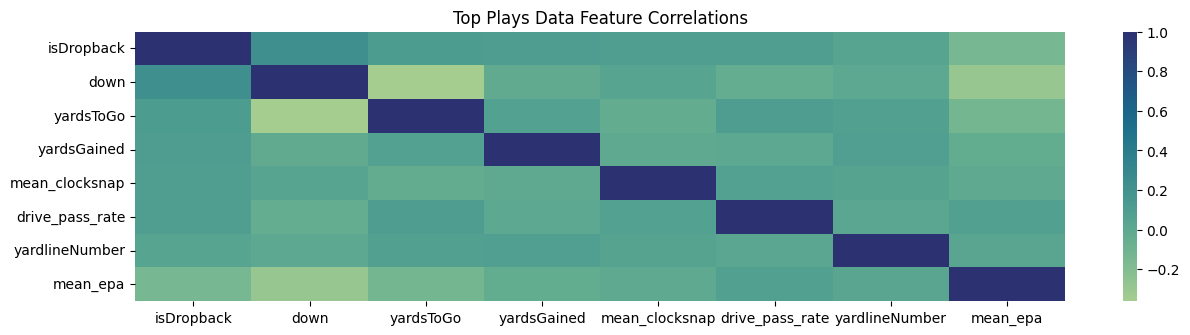

In [6]:
top_cols = df_plays.corr()['isDropback'].sort_values(ascending=False).head(9).index
plt.figure(figsize=(15,3.5))
sns.heatmap(df_plays[[x for x in top_cols if 'prePenaltyYardsGained' not in x and 'playAction' not in x]+['mean_epa']].corr(), cmap="crest")


plt.title('Top Plays Data Feature Correlations');
plt.xticks(rotation=0);

In [7]:
df_plays[[x for x in top_cols if 'prePenaltyYardsGained' not in x and 'playAction' not in x]+['mean_epa']].corr()

,isDropback,down,yardsToGo,yardsGained,mean_clocksnap,drive_pass_rate,yardlineNumber,mean_epa
isDropback,1.000000,0.224039,0.114515,0.103167,0.092108,0.090912,0.045002,-0.143403
down,0.224039,1.000000,-0.361761,-0.017346,0.044751,-0.047711,0.005717,-0.292802
yardsToGo,0.114515,-0.361761,1.000000,0.072102,-0.033155,0.105889,0.077999,-0.123976
yardsGained,0.103167,-0.017346,0.072102,1.000000,-0.000382,0.007404,0.085599,-0.029446
mean_clocksnap,0.092108,0.044751,-0.033155,-0.000382,1.000000,0.066497,0.051834,-0.001560
drive_pass_rate,0.090912,-0.047711,0.105889,0.007404,0.066497,1.000000,0.022614,0.074885
yardlineNumber,0.045002,0.005717,0.077999,0.085599,0.051834,0.022614,1.000000,0.026696
mean_epa,-0.143403,-0.292802,-0.123976,-0.029446,-0.001560,0.074885,0.026696,1.000000


In [65]:
df_plays['tempo'] = .1*df_plays['mean_clocksnap'] + df_plays['drive_pass_rate']
df_plays['tempo'] = df_plays['tempo']/df_plays['tempo'].max()

In [66]:
import pandas as pd
from sklearn import preprocessing

In [67]:
df_plays[['mean_clocksnap','drive_pass_rate','tempo','isDropback']].head(3)

,mean_clocksnap,drive_pass_rate,tempo,isDropback
0,10.0,0.6,0.405063,True
1,12.0,1.0,0.556962,True
2,14.0,1.0,0.607595,False


In [68]:
df_plays[['mean_clocksnap','drive_pass_rate','tempo','isDropback']].corr()['isDropback']

mean_clocksnap     0.092108
drive_pass_rate    0.090912
tempo              0.124493
isDropback         1.000000
Name: isDropback, dtype: float64